## Visualisation
This code uses the output from MWATS_average_SQL and provides basic visualisation functionality. 

In [1]:
import requests
import numpy as np
import plots as pl
import pandas as pd
import matplotlib.pyplot as plt 
import aplpy 
import os
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/134393/anaconda3/lib/python3.7/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


In [2]:
def query(ra, dec, radius=5):
    url = f"http://simbad.u-strasbg.fr/simbad/sim-coo?Coord={ra}d{dec}d&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius={radius}&Radius.unit=arcmin&submit=submit+query"
    return url

In [3]:
def get_response(ra, dec, radius=5):
    url = query(ra, dec, radius)
    response = requests.get(url)
    tables = pd.read_html(response.text)
    idx = np.argmax(['Identifier' in t.columns for t in tables])
    table = tables[idx]
    try:
        identifier = table.loc[0, 'Identifier']
    except KeyError:
        identifier = 'No object found'
    return identifier, url, table

In [4]:
# Generic function for plotting light-curves and stats.
def plot_lc(source):
    all = filtered_raw_data[filtered_raw_data.source_id == source]
    all = all.sort_values(by='jd')
    plt.figure(figsize=(7, 8))
    plt.subplot(2,1,1)
    f = list(all.raw_peak_flux)
    s_stats = stats[stats.source_id == source]
    plt.title(str(source)+' RA='+str(round(s_stats.ra.values[0], 3))+' DEC='+str(round(s_stats.dec.values[0], 3)))
    #plt.title(str(source)+' RA='+str(s_stats.ra)+' DEC='+str(s_stats.dec))
    plt.plot(list(f), 'k.', label='Flux')
    plt.xlabel('Observation Number')
    plt.ylabel('Flux (Jy)')
    # Non-averaged
    plt.subplot(2,1,2)
    plt.plot(all.jd, all.raw_peak_flux, 'k.', label='Flux')
    ts = []
    ys = []
    for t in all.jd:
        sli = stats[stats.source_id == source]
        y = (sli.grad * t) + sli.y_int
        ts.append(float(t))
        ys.append(float(y))
    plt.plot(ts,ys,'k-.', label='$\\nabla_{S} = $'+str( round(float(sli.sig),2) ))
        
    # Averaged 
    avg = filtered_raw_avg_data[filtered_raw_avg_data.source_id == source]
    plt.errorbar(avg.mean_jd, avg.median_flux, avg.std_flux, fmt='ro', label="Median flux", markersize=10)
    ts = []
    ys = []
    for t in avg.mean_jd:
        sli = stats[stats.source_id == source]
        y = (sli.avg_grad * t) + sli.avg_y_int
        ts.append(float(t))
        ys.append(float(y))
    plt.plot(ts,ys,'r-.', label='Median $\\nabla_{S} = $'+str( round(float(sli.avg_sig),2) ))
    #plt.ylim(np.mean(f)*0.8, np.mean(f)*1.2)
    plt.xlabel('Time (JD)')
    plt.ylabel('Flux (Jy)')
    plt.savefig('thumbs/'+str(source)+'_Avg_LC.jpg')
    plt.legend()
    plt.close

In [5]:
def get_image(source_id):
    exists = os.path.isfile('thumbs/'+str(source_id)+'.jpg')
    if not exists:
        # Select random image
        plt.figure(figsize=[10,12])
        image = filtered_raw_data[filtered_raw_data.source_id == source_id].image.sample(1).values[0]
        s_stats = stats[stats.source_id == source_id]
        grid = True
        size=(600, 600)
        dpi = 40
        figure = aplpy.FITSFigure('/Volumes/BEL27A-BKP01/MWATS/'+image, dimensions=[0,1], slices=[0,0], auto_refresh=False, dpi = dpi, figsize = (size[0] / float(dpi), size[1] / float(dpi)))
        ra = s_stats.ra.values[0]
        dec = s_stats.dec.values[0]
        circle_size = 1.0 # 1 degree circle
        figure.recenter(ra, dec, radius=1.0, width=2.0, height=2.0)
        #figure.recenter(ra, dec, circle_size) 
        if grid:
            try:
                figure.add_grid()
            except Exception as e:
                logging.warn("APLpy error adding grid to image: {0}".format(e))
        # Adjust the axis labels, otherwise they overlap
        # If the image is less than two arc minutes across, show seconds on the tick labels
    
        image_radius = circle_size
        if image_radius < 1.0 / 60.0 * 2:
                figure.tick_labels.set_xformat("hh:mm:ss")
                figure.tick_labels.set_yformat("dd:mm:ss")
        else:
                figure.tick_labels.set_xformat("hh:mm")
                figure.tick_labels.set_yformat("dd:mm")

        figure.tick_labels.set_xformat("dd:mm")
        figure.tick_labels.set_yformat("dd:mm")
        figure.show_grayscale(pmin=5.0, pmax=99.5, invert=False)
        figure.add_colorbar()
        # Show locations of the neighbours
        figure.show_rectangles(ra, dec, 0.1, 0.1, edgecolor='k', linewidth=2.0)
        n = neighbours[neighbours.source_id == source_id]
        for num in range(5):
            if num == 0:
               neigh = n.n_id1.values[0]
               nra  =  n.n_id1_ra.values[0]
               ndec =  n.n_id1_dec.values[0]
               colour = 'm'
            if num == 1:
               neigh = n.n_id2.values[0]
               nra  =  n.n_id2_ra.values[0]
               ndec =  n.n_id2_dec.values[0]
               colour = 'y'
            if num == 2:
               neigh = n.n_id3.values[0]
               nra  =  n.n_id3_ra.values[0]
               ndec =  n.n_id3_dec.values[0]
               colour = 'c'
            if num == 3:
               neigh = n.n_id4.values[0]
               nra  =  n.n_id4_ra.values[0]
               ndec =  n.n_id4_dec.values[0]
               colour = 'b'
            if num == 4:
               neigh = n.n_id5.values[0]
               nra  =  n.n_id5_ra.values[0]
               ndec =  n.n_id5_dec.values[0]
               colour = 'r'
            #n_stats = stats[stats.source_id == neigh]
            #print(n_stats)
            figure.show_ellipses(nra, ndec, 0.1, 0.1, edgecolor=colour, linewidth=2.0)
        figure.save('thumbs/'+str(source_id)+'.jpg')
        figure.close()

In [6]:
def plot_n_lc(source):
    plt.figure(figsize=[8,6])
    #plt.subplot(2,1,1)
    gs = gridspec.GridSpec(3, 2)
    n = neighbours[neighbours.source_id == source]
    for num in range(5):
        if num == 0:
               neigh = n.n_id1.values[0]
               colour = 'm'
        if num == 1:
               neigh = n.n_id2.values[0]
               colour = 'y'
        if num == 2:
               neigh = n.n_id3.values[0]
               colour = 'c'
        if num == 3:
               neigh = n.n_id4.values[0]
               colour = 'b'
        if num == 4:
               neigh = n.n_id5.values[0]
               colour = 'r'
        #plt.subplot2grid((3, 2), (num, 0))    
        plt.subplot(gs[num])    
        #plt.subplot(3,2,num+1)
        s_stats = stats[stats.source_id == source]
        #plt.title(str(source)+' RA='+str(round(s_stats.ra.values[0], 3))+' DEC='+str(round(s_stats.dec.values[0], 3)))
        main = filtered_raw_data[filtered_raw_data.source_id == source]
        main = main.sort_values(by='jd')
        n = neighbours[neighbours.source_id == source]
        n_data = filtered_raw_data[filtered_raw_data.source_id == neigh]
        n_data = n_data.sort_values(by='jd')

        main = main.set_index('time')
        n_data = n_data.set_index('time')

        result = pd.concat([main, n_data])
        result = result.sort_values(by='time')

        image_ids = list(result.image_id)

        count = 0
        counts = []
        counts.append(count)
        for i in range(len(image_ids)-1):
            if image_ids[i+1]-image_ids[i] == 0:
               count = count
            else: 
               count = count + 1
            counts.append(count)

        result['counts'] = counts

        p1 = result[result.source_id == source] 
        p2 = result[result.source_id == neigh]
    
        plt.plot(p2.counts, p2.raw_peak_flux, color=colour, markersize=5, marker='.', label='Neighbour', alpha=0.5)
        plt.plot(p1.counts, p1.raw_peak_flux, 'ko-.', label='Main', alpha=0.5)

        plt.ylabel('Flux (Jy)')
        plt.xlabel('Image sequence (N)')
        #plt.legend()
    
    # Plot the gain
    plt.subplot(gs[5])
    plt.plot(list(main.Gain), 'ko', alpha=0.5)
    plt.ylabel('Gain')
    plt.xlabel('Image sequence (N)')
    plt.tight_layout()
    plt.savefig('thumbs/'+str(source)+'_LCS.jpg')
    plt.close()


In [7]:
# Load the data
stats = pd.read_feather('stats_table.fth')
filtered_raw_data = pd.read_feather('data.fth')
filtered_raw_avg_data = pd.read_feather('avg_data.fth')
neighbours = pd.read_feather('neighbours.fth')

### View interesting light-curves:

In [63]:
avg_sig_cut = 0.0
avg_flux_cut = 0.25
avg_Mod_cut = 30
Mod_cut = 0.0

interesting = stats[ ( ( stats.avg_sig.abs() ) > avg_sig_cut )             
             & (stats.mean_raw_peak_flux > avg_flux_cut)
             & (stats.avg_Mod > avg_Mod_cut) 
             & (stats.Mod > Mod_cut) ]

len(interesting) # How many objects we have in our cut.

61

KeyboardInterrupt: 

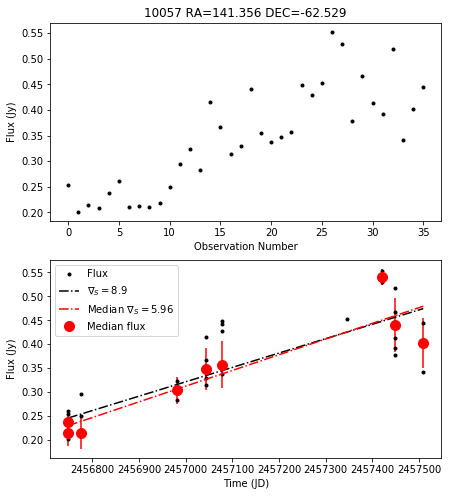

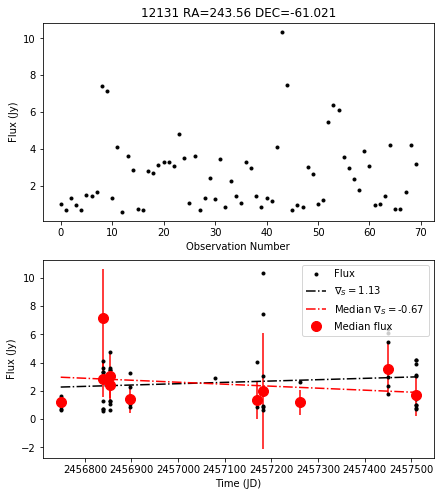

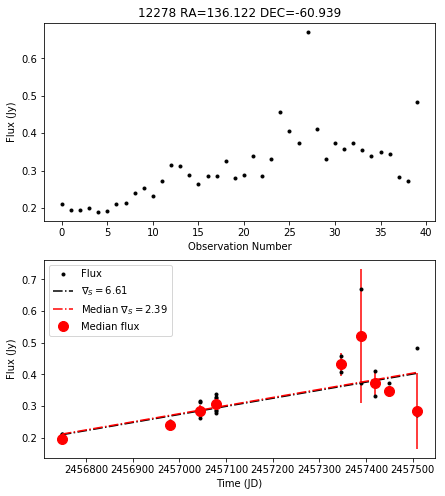

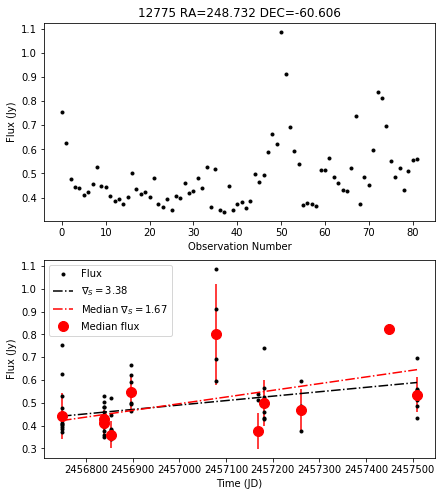

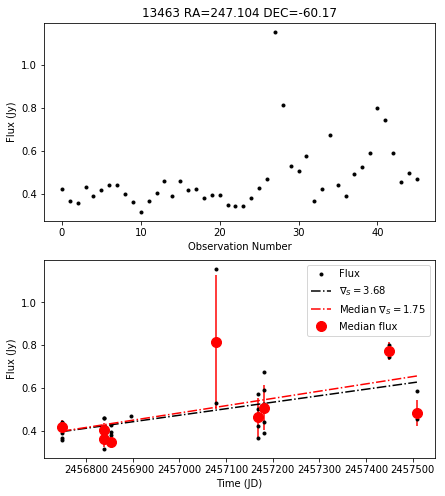

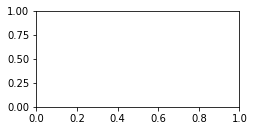

In [37]:
# Make plots of those sources. 
for n in interesting.source_id:
   plot_lc(n)
   plot_n_lc(n)
   get_image(n)

In [64]:
plot_link = []
LC_link = []
avg_link = []
url = []
count = 0
for s in (list(interesting.source_id)):
    plot_link.append("<img src=\'thumbs/"+str(s)+".jpg\'>") 
    LC_link.append("<img src=\'thumbs/"+str(s)+"_LCS.jpg\'>") 
    avg_link.append("<img src=\'thumbs/"+str(s)+"_Avg_LC.jpg\'>") 
    url.append('<a href="http://simbad.u-strasbg.fr/simbad/sim-coo?Coord='+str(interesting.ra.values[count])+'d+'+str(interesting.dec.values[count])+'d&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin&submit=submit+query">Simbad Link</a>')
    count +=1

In [65]:
interesting.insert(0, 'Thumb', plot_link)
interesting.insert(1, 'LCs', LC_link)
interesting.insert(2, 'Avg LC', avg_link)
interesting.insert(3, 'URL', url)

# Add in Simbad indentifiers

In [68]:
tmp = interesting.apply(lambda source: get_response(source.ra, source.dec)[0], axis=1)
interesting.insert(4, 'candidate', tmp)

# RESULTS

In [69]:
pd.set_option('display.max_colwidth', -1)
HTML(interesting.to_html(escape=False))

,Thumb,LCs,Avg LC,URL,candidate,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,sig,grad,fit_error,y_int,avg_sig,avg_grad,avg_fit_error,avg_y_int,avg_std,avg_median,avg_Mod
2431,,,,Simbad Link,TYC 8944-2490-1,2455,10057,141.356216,-62.528659,0.344761,0.101120,29.330620,36,8.899923,0.000300,0.000034,-737.705074,5.960626,3.279945e-04,0.000055,-805.570112,0.110607,0.339858,32.545129
3120,,,,Simbad Link,[SWK2009] K154,3154,12131,243.560256,-61.021059,2.573485,1.978635,76.885424,70,1.129493,0.000947,0.000838,-2323.165422,-0.670967,-1.407931e-03,0.002098,3461.891655,1.738782,2.528826,68.758477
3169,,,,Simbad Link,TYC 8927-3589-1,3203,12278,136.121885,-60.939231,0.309493,0.093794,30.305509,40,6.605067,0.000255,0.000039,-626.452680,2.391868,2.560936e-04,0.000107,-628.946049,0.100277,0.331662,30.234593
3335,,,,Simbad Link,NGC 6156,3373,12775,248.732186,-60.606275,0.489604,0.135700,27.716182,82,3.381805,0.000194,0.000057,-475.696871,1.672818,2.933660e-04,0.000175,-720.304468,0.157356,0.517838,30.387169
3544,,,,Simbad Link,TYC 9037-4044-1,3584,13463,247.104142,-60.170293,0.472586,0.154248,32.639177,46,3.680821,0.000304,0.000083,-746.511998,1.753167,3.393851e-04,0.000194,-833.385879,0.170455,0.508401,33.527771
3914,,,,Simbad Link,TYC 8738-2226-1,3960,14679,255.990237,-59.428521,0.473437,0.112490,23.760318,127,2.816690,0.000107,0.000038,-262.558478,1.470849,2.536167e-04,0.000172,-622.646702,0.154613,0.503875,30.684893
4044,,,,Simbad Link,TYC 8725-656-1,4092,15168,252.580321,-59.125037,0.481511,0.109114,22.660823,138,3.229479,0.000113,0.000035,-276.835399,2.050506,3.372546e-04,0.000164,-828.145268,0.161104,0.507651,31.735229
4067,,,,Simbad Link,LEDA 373963,4117,15239,317.632843,-59.071435,0.280036,0.088931,31.757086,82,-0.242664,-0.000011,0.000044,26.559324,-0.167654,-2.606141e-05,0.000155,64.336991,0.126420,0.304646,41.497432
4078,,,,Simbad Link,PKS 1520-58,4128,15278,231.216351,-59.052083,0.562653,0.171604,30.499142,109,6.351148,0.000341,0.000054,-837.985944,2.702468,5.213349e-04,0.000193,-1280.417354,0.215673,0.559750,38.530276
5321,,,,Simbad Link,IRAS 15107-5643,5397,19477,228.564304,-56.892016,0.456981,0.129726,28.387591,103,6.087339,0.000263,0.000043,-644.816420,2.636801,3.431332e-04,0.000130,-842.662839,0.143914,0.453105,31.761738


## Location plots

In [ ]:
def write_mod(ra, dec):
    rad = 400
    colour_str = '# color = green'
    f.write('circle('+str(ra)+','+str(dec)+','+str(rad)+'\") '+colour_str)
    f.write('\n')
    
def write_mod_2(ra, dec):
    rad = 450
    colour_str = '# color = red'
    f.write('circle('+str(ra)+','+str(dec)+','+str(rad)+'\") '+colour_str)
    f.write('\n')    

def write_line(ra1, dec1, ra2, dec2):
    times = 1.00
    f.write('line('+str(ra1)+','+str(dec1)+','+str(ra2*times)+','+str(dec2*times)+')')
    f.write('\n')
    
f  = open("close.reg", "w")
f.write('fk5')
f.write('\n')

In [ ]:
close_ra = list(close_source.source_id_ra)
close_dec = list(close_source.source_id_dec)
close_ra_n = list(close_source.n_id1_ra)
close_dec_n = list(close_source.n_id1_dec)
for i in range(len(close_ra)):
    write_mod(close_ra[i], close_dec[i])
    write_mod_2(close_ra_n[i], close_dec_n[i])
    write_line(close_ra[i], close_dec[i],close_ra_n[i], close_dec_n[i])